# Implementación de autoencoders 

En esta guía, se responden algunas preguntas típicas sobre autoencoders y se cubren ejemplos de código de los siguientes modelos:

- un codificador automático simple basado en una capa completamente conectada
- un codificador automático escaso
- un codificador automático profundo y completamente conectado
- un codificador automático convolucional profundo
- un modelo de eliminación de ruido de imágenes
- un codificador automático secuencia a secuencia
- un codificador automático variacional

*Nota: se necesita la versión 2.0.0 o superior de Keras para ejecutarlos.*

In [ ]:
!pip show keras

Name: Keras
Version: 2.4.3
Summary: Deep Learning for humans
Home-page: https://github.com/keras-team/keras
Author: Francois Chollet
Author-email: francois.chollet@gmail.com
License: MIT
Location: /usr/local/lib/python3.7/dist-packages
Requires: pyyaml, scipy, h5py, numpy
Required-by: keras-vis


## Repaso teórico
### ¿Qué son los autoencoders?

Un autoencoder es un algoritmo de compresión de datos que permite "aprender" automáticamente la función de compresión y la de descompresión. Por regla general, ambas funciones se implementan haciendo uso de redes neuronales.

Hay tres factores importantes a tener en cuenta:

- Los autoencoders son específicos para cada conjunto de datos, lo que significa que solo podrán comprimir datos similares a los que han utilizado para ser entrenados. Esto es diferente de, digamos, el algoritmo de compresión MPEG-2 Audio Layer III (MP3), que admite suposiciones sobre el "sonido" en general, pero no sobre tipos específicos de sonidos. Un autoencoder entrenado en imágenes de rostros haría un trabajo bastante pobre al comprimir imágenes de árboles, porque las características que aprendería serían específicas de cada rostro.

- Los autoencoders tienen pérdida, lo que significa que las salidas descomprimidas se degradarán en comparación con las entradas originales (similar a la compresión MP3 o JPEG). Esto difiere de la compresión aritmética sin pérdidas.

- Los autoencoders aprenden automáticamente a partir de ejemplos de datos, lo cual es una propiedad útil: significa que es fácil entrenar instancias especializadas del algoritmo que funcionarán bien en un tipo específico de entrada. No requiere ninguna nueva ingeniería, solo datos de entrenamiento apropiados.

Por otro lado, para implementar un autoencoder, se necesitan tres componentes: 
- Una función de codificación
- Una función de decodificación 
- Una función de pérdida 

### ¿Son buenos en la compresión de datos?

Por lo general, no realmente. En la compresión de imágenes, por ejemplo, es bastante difícil entrenar un autoencoder que haga un mejor trabajo que un algoritmo básico como JPEG y, por lo general, la única forma de lograrlo es restringiéndose a un tipo de imagen muy específico (por ejemplo, uno para el que JPEG no haga un buen trabajo). El hecho de que los autoencoders sean específicos de datos los hace generalmente poco prácticos para los problemas de compresión de datos del mundo real: solo pueden usarse en datos que sean similares a los que se usaron para entrenar, y hacerlos más generales, por lo tanto, requiere muchos datos de entrenamiento. Es posible que los futuros avances cambien esta limitación.

### ¿Para qué sirven los autoencoders?
Rara vez se utilizan en aplicaciones prácticas. En 2012 encontraron brevemente una aplicación en el preentrenamiento por capas para redes neuronales convolucionales profundas, pero esto rápidamente pasó de moda cuando los desarrolladores comenzaron a darse cuenta de que mejores esquemas de inicialización de peso aleatorio eran suficientes para entrenar redes profundas desde cero. En 2014, la normalización por lotes comenzó a permitir redes aún más profundas, y desde finales de 2015 fue posible entrenar redes profundas arbitrariamente desde cero utilizando otras técnicas modernas.

Hoy en día, dos aplicaciones prácticas interesantes de los codificadores automáticos son la eliminación de ruido de datos y la reducción de dimensionalidad para la visualización de datos. Con las restricciones de dimensionalidad y escasez (*sparsity*) adecuadas, los autoencoders pueden aprender proyecciones de datos que son más interesantes que el PCA u otras técnicas básicas.

### Entonces, ¿por qué se son tan populares?
Una de las razones por las que han atraído tanta investigación y atención es porque durante mucho tiempo se pensó que eran una vía potencial para resolver el problema del aprendizaje no supervisado, es decir, el aprendizaje de representaciones útiles sin la necesidad de etiquetas. Por otra parte, los autoencoders no son una verdadera técnica de aprendizaje no supervisado (lo que implicaría un proceso de aprendizaje completamente diferente), sino una técnica auto-supervisada, una instancia específica de aprendizaje supervisado donde los objetivos se generan a partir de los datos de entrada.

## Implementación en Keras

In [1]:
## Implementación en Keras

import keras
from keras import layers
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [27]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

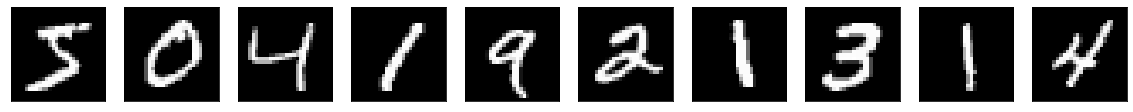

In [7]:
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_train[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

## Autoencoder simple

In [24]:
encoding_dim = 32 # 32 floats -> compresión de factor 24.5, asumiendo que el input contiene 784 valores (píxeles)

autoencoder = tf.keras.Sequential()

# Encoding
autoencoder.add(layers.Dense(encoding_dim, activation= "relu", input_shape = (784,)))

# Decoding
autoencoder.add(layers.Dense(784, activation = "sigmoid"))

In [28]:
X_train = X_train / 255.
X_test = X_test / 255.

In [29]:
X_train.shape

(60000, 28, 28)

In [30]:
X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

In [31]:
X_train.shape

(60000, 784)

In [32]:
autoencoder.compile(loss = "binary_crossentropy",
                    metrics = ["accuracy"],
                    optimizer = "adam")

In [33]:
autoencoder.fit(X_train, X_train,
                epochs = 50,
                batch_size = 256,
                shuffle = True,
                validation_data = (X_test, X_test))

Epoch 1/50
235/235 [==============================] - 4s 14ms/step - loss: 0.2762 - accuracy: 0.0107 - val_loss: 0.1904 - val_accuracy: 0.0123
Epoch 2/50
235/235 [==============================] - 3s 12ms/step - loss: 0.1696 - accuracy: 0.0115 - val_loss: 0.1522 - val_accuracy: 0.0106
Epoch 3/50
235/235 [==============================] - 3s 13ms/step - loss: 0.1434 - accuracy: 0.0097 - val_loss: 0.1334 - val_accuracy: 0.0087
Epoch 4/50
235/235 [==============================] - 3s 14ms/step - loss: 0.1286 - accuracy: 0.0095 - val_loss: 0.1216 - val_accuracy: 0.0096
Epoch 5/50
235/235 [==============================] - 3s 13ms/step - loss: 0.1184 - accuracy: 0.0106 - val_loss: 0.1131 - val_accuracy: 0.0109
Epoch 6/50
235/235 [==============================] - 3s 13ms/step - loss: 0.1113 - accuracy: 0.0114 - val_loss: 0.1071 - val_accuracy: 0.0118
Epoch 7/50
235/235 [==============================] - 3s 13ms/step - loss: 0.1062 - accuracy: 0.0117 - val_loss: 0.1029 - val_accuracy: 0.0117

In [34]:
decoded_imgs = autoencoder.predict(X_test)

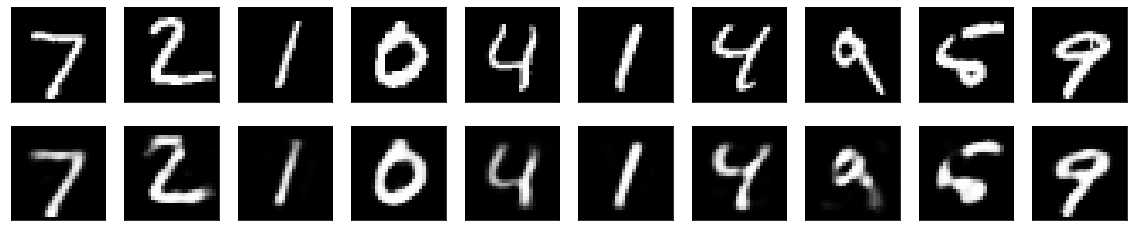

In [35]:
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Autoencoder para eliminar ruido de imágenes

In [2]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

11493376/11490434 [==============================] - 0s 0us/step


In [3]:
# Metemos ruido a las imágenes
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

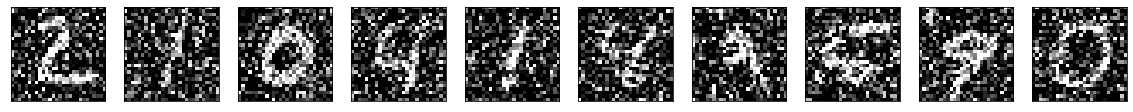

In [4]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [5]:
autoencoder2 = tf.keras.Sequential()

# Entrada
#autoencoder2.add(layers.Input(shape = (28, 28, 1)))

# 1er bloque
autoencoder2.add(layers.Conv2D(32, 
                               (3, 3),
                               activation = "relu",
                               padding = "same",
                               input_shape = (28, 28, 1)))
autoencoder2.add(layers.MaxPool2D((2,2)))
autoencoder2.add(layers.Conv2D(32, 
                               (3, 3),
                               activation = "relu",
                               padding = "same"))
autoencoder2.add(layers.MaxPool2D((2,2)))

# 2º bloque
autoencoder2.add(layers.Conv2D(32, 
                               (3, 3),
                               activation = "relu",
                               padding = "same"))
autoencoder2.add(layers.UpSampling2D(size=(2, 2)))
autoencoder2.add(layers.Conv2D(32, 
                               (3, 3),
                               activation = "relu",
                               padding = "same"))
autoencoder2.add(layers.UpSampling2D(size=(2, 2)))

# Capa de salida
autoencoder2.add(layers.Conv2D(1, (3, 3), activation= "sigmoid", padding = "same"))

In [6]:
autoencoder2.compile(optimizer = "adam",
                     loss = "binary_crossentropy")

In [7]:
autoencoder2.fit(x_train_noisy, x_train,
                 epochs = 10,
                 batch_size = 128,
                 shuffle = True,
                 validation_data = (x_test_noisy, x_test))

Epoch 1/10
469/469 [==============================] - 36s 9ms/step - loss: 0.1630 - val_loss: 0.1187
Epoch 2/10
469/469 [==============================] - 4s 8ms/step - loss: 0.1138 - val_loss: 0.1086
Epoch 3/10
469/469 [==============================] - 4s 8ms/step - loss: 0.1077 - val_loss: 0.1048
Epoch 4/10
469/469 [==============================] - 4s 8ms/step - loss: 0.1047 - val_loss: 0.1035
Epoch 5/10
469/469 [==============================] - 4s 8ms/step - loss: 0.1029 - val_loss: 0.1012
Epoch 6/10
469/469 [==============================] - 4s 8ms/step - loss: 0.1015 - val_loss: 0.1002
Epoch 7/10
469/469 [==============================] - 4s 8ms/step - loss: 0.1005 - val_loss: 0.0993
Epoch 8/10
469/469 [==============================] - 4s 8ms/step - loss: 0.0997 - val_loss: 0.0988
Epoch 9/10
469/469 [==============================] - 4s 8ms/step - loss: 0.0990 - val_loss: 0.0981
Epoch 10/10
469/469 [==============================] - 4s 8ms/step - loss: 0.0985 - val_loss: 0.098

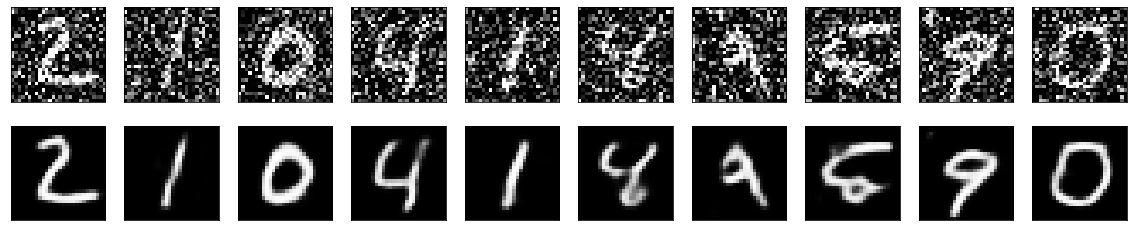

In [8]:
decoded_imgs = autoencoder2.predict(x_test_noisy)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()